# Equity premium prediction with python and Keras

* An exploratory data analysis and a demo of classification using Keras
* Using [dataset](http://www.hec.unil.ch/agoyal/docs/PredictorData2016.xlsx) from [Prof. Amit Goyal](http://www.hec.unil.ch/agoyal/), attempt to predict quarterly equity outperformance based on fundamental data like interest rates, valuation.
* Train binary classifier to predict whether next quarter's equity premium will be above or below long term average


In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight

from pprint import pprint
import time
import copy


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

#use a fixed seed for reproducibility
seed = np.random.randint(10000, size=1)[0]
print(seed)
#seed = 6016
np.random.seed(seed)


Using TensorFlow backend.


1732


In [2]:
############################################################
# 1. load data
############################################################

# load dataset
print("Loading data...")
dataframe = pd.read_csv("EqPremClass.csv")
dataframe

Loading data...


,Unnamed: 0,D12,E12,b.m,tbl,AAA,BAA,lty,ntis,infl,...,ltr.diff,corpr.diff,svar.diff,tbl.lagdiff,AAA.lagdiff,BAA.lagdiff,lty.lagdiff,ltr.lagdiff,corpr.lagdiff,EqPremResponse
0,3,0.770,1.110,0.374689,0.0317,0.050313,0.058913,0.037313,0.076475,-0.005713,...,0.012577,-0.004409,0.000268,-0.0035,-0.011438,-0.012138,-0.012838,0.030167,0.005259,1
1,4,0.790,1.177,0.363255,0.0327,0.044430,0.053030,0.031530,0.054364,0.000170,...,-0.020049,-0.005564,-0.000161,0.0013,0.016741,0.015941,0.015041,0.007711,-0.000199,0
2,5,0.810,1.245,0.370300,0.0392,0.045530,0.055330,0.032430,0.050299,0.000170,...,-0.011019,-0.022453,0.004100,-0.0013,-0.029141,-0.028641,-0.028441,-0.038657,-0.012230,1
3,6,0.830,1.312,0.328166,0.0457,0.040150,0.049950,0.028650,0.027980,0.005950,...,-0.014276,0.019109,-0.003478,-0.0039,0.011161,0.010261,0.011161,0.011038,0.014918,1
4,7,0.850,1.380,0.259667,0.0426,0.051744,0.061644,0.039644,0.063069,-0.005644,...,0.034818,0.002796,0.002725,0.0049,-0.006513,-0.006713,-0.007113,0.012577,-0.004409,1
5,8,0.880,1.438,0.272300,0.0460,0.064443,0.075343,0.055143,0.079805,-0.017443,...,-0.055116,-0.014560,0.001703,0.0010,-0.005882,-0.005882,-0.005782,-0.020049,-0.005564,1
6,9,0.910,1.495,0.253581,0.0480,0.088744,0.100444,0.077744,0.116197,-0.041044,...,0.060579,0.003230,0.000422,0.0065,0.001100,0.002300,0.000900,-0.011019,-0.022453,1
7,10,0.940,1.552,0.244868,0.0458,0.113384,0.126584,0.102884,0.121390,-0.065384,...,-0.022683,0.005639,-0.000348,0.0065,-0.005380,-0.005380,-0.003780,-0.014276,0.019109,0
8,11,0.970,1.610,0.338458,0.0303,0.125698,0.138498,0.112998,0.163522,-0.078998,...,0.053953,0.017375,0.092115,-0.0031,0.011594,0.011694,0.010994,0.034818,0.002796,1
9,12,0.973,1.450,0.319119,0.0295,0.151332,0.162432,0.138632,0.145496,-0.105132,...,-0.037758,0.002332,-0.095509,0.0034,0.012700,0.013700,0.015500,-0.055116,-0.014560,0


In [3]:
# pandas dataframe -> numpy ndarray
dataset = dataframe.values
del dataframe

In [4]:
num_obs, num_features = dataset.shape
num_features -=1
num_labels=1
print("Observations: %d\nFeatures: %d" % (num_obs, num_features))

# last column is target 
y=dataset[:,num_features].astype(float)
print("Histogram: check all 0s and 1s, no -1s etc.")
pprint(np.histogram(y))

# omit 1st id column
X_raw = dataset[:,1:num_features].astype(float)
num_features -=1
del dataset

# normalize
# not necessary for NN but may speed convergence, lets pca work
# min_max_scaler = preprocessing.MinMaxScaler()
# X = min_max_scaler.fit_transform(X_raw)
X = preprocessing.scale(X_raw)

pd.DataFrame(X)

Observations: 352
Features: 31
Histogram: check all 0s and 1s, no -1s etc.
(array([176,   0,   0,   0,   0,   0,   0,   0,   0, 176]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.767621,-0.689589,-0.774685,-0.099709,0.519319,0.428291,0.379438,2.381861,-0.910326,0.266007,...,0.421662,0.185423,-0.071273,0.018805,-0.398291,-0.782983,-0.821576,-0.870520,0.451925,0.085675
1,-0.765478,-0.686961,-0.817516,-0.067674,0.380785,0.297435,0.240222,1.486580,-0.762275,-0.164262,...,0.434384,-0.299704,-0.089852,-0.014161,0.163439,1.163271,1.096738,1.035651,0.114856,-0.002960
2,-0.763335,-0.684293,-0.791125,0.140554,0.406691,0.348599,0.261890,1.321980,-0.762275,-0.400750,...,-0.006831,-0.165443,-0.361633,0.313814,-0.140831,-2.005689,-1.949039,-1.937349,-0.581140,-0.198327
3,-0.761192,-0.681664,-0.948962,0.348782,0.279979,0.228911,0.170875,0.418281,-0.616790,-0.707137,...,0.426733,-0.213873,0.307189,-0.269523,-0.445101,0.777854,0.708668,0.770342,0.164790,0.242523
4,-0.759049,-0.678996,-1.205563,0.249473,0.553026,0.489048,0.435564,1.839043,-0.908595,0.040092,...,-0.876449,0.516128,0.044673,0.207974,0.584736,-0.442798,-0.450921,-0.479058,0.187893,-0.071330
5,-0.755834,-0.676721,-1.158236,0.358393,0.852110,0.793800,0.808729,2.516687,-1.205575,-1.142770,...,-0.891871,-0.821140,-0.234620,0.129286,0.128331,-0.399259,-0.394191,-0.388096,-0.301823,-0.090078
6,-0.752620,-0.674484,-1.228362,0.422463,1.424413,1.352177,1.352862,3.990253,-1.799575,0.157329,...,-1.777035,0.899185,0.051657,0.030703,0.771979,0.082991,0.164810,0.068793,-0.166292,-0.364338
7,-0.749405,-0.672248,-1.260999,0.351986,2.004710,1.933677,1.958135,4.200511,-2.412188,-0.329478,...,-1.832500,-0.338877,0.090419,-0.028619,0.771979,-0.364587,-0.359895,-0.251214,-0.215180,0.310585
8,-0.746191,-0.669973,-0.910407,-0.144558,2.294717,2.198710,2.201640,5.906464,-2.754837,0.828413,...,-1.027973,0.800656,0.279277,7.089744,-0.351480,0.807774,0.806583,0.758939,0.521726,0.045674
9,-0.745869,-0.676250,-0.982851,-0.170187,2.898424,2.731137,2.818806,5.176581,-3.412602,0.018082,...,-1.967060,-0.563031,0.037204,-7.354659,0.409195,0.884135,0.943601,1.066998,-0.828192,-0.236167


In [5]:
print("Split into training, xval, test")
# split into training, xval, test, 60/20/20
X_bigtrain, X_test, y_bigtrain, y_test = train_test_split(X, y, test_size=0.2)
print("Split into train, xval")
X_train, X_xval, y_train, y_xval = train_test_split(X_bigtrain, y_bigtrain, test_size=0.25)

print "Training set"
print X_train.shape
pprint(np.histogram(y_train))

print "Xval set"
print X_xval.shape
pprint(np.histogram(y_xval))

print "Test set"
print X_test.shape
pprint(np.histogram(y_test))

Split into training, xval, test
Split into train, xval
Training set
(210, 30)
(array([103,   0,   0,   0,   0,   0,   0,   0,   0, 107]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Xval set
(71, 30)
(array([36,  0,  0,  0,  0,  0,  0,  0,  0, 35]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
Test set
(71, 30)
(array([37,  0,  0,  0,  0,  0,  0,  0,  0, 34]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))


[ 18.29  34.6   45.39  55.11  63.01  68.51  73.64  77.94  82.02  85.13
  88.11  90.65  92.88  94.82  96.29  97.47  98.44  98.86  99.22  99.54
  99.65  99.76  99.83  99.89  99.93  99.95  99.97  99.98  99.99  99.99]


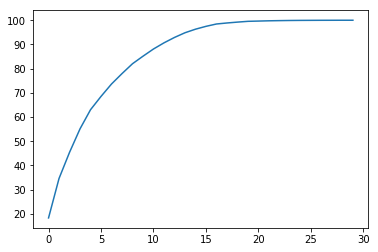

In [6]:
# principal component analysis
# scree chart to see how much variation is explained by how many predictors

# we can predict using PCA components for dimensionality reduction when we have too many/collinear columns
# can speed things up or sometimes get a better result
# but won't do that here
# merely exploratory to understand the data, see that it's scaled

pca = PCA(n_components=num_features)
pca.fit(X_train)

#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

#print(var1)
%matplotlib inline
plt.plot(var1)
print(var1)
# looks like ~10 orthogonal PCA components explain > 80% of the variation

num_pca_components=15
pca = PCA(n_components=num_pca_components)
pca.fit(X_train)

pca_train=pca.transform(preprocessing.normalize(X_train))
pca_bigtrain=pca.transform(preprocessing.normalize(X_bigtrain))
pca_xval=pca.transform(preprocessing.normalize(X_xval))
pca_test=pca.transform(preprocessing.normalize(X_test))

In [22]:
# function to generate Keras feed-forward neural network model

def declare_model(num_components=num_features, 
                  hidden_layer_size=30, 
                  dropout=(1.0/3.0), 
                  reg_penalty=0.0001, 
                  activation='relu'):
    # create model
    model = Sequential()
    # 1 hidden layer of specified size hidden_layer_size, specified L1 regularization, specified activation
    model.add(Dense(hidden_layer_size, 
                    input_dim=num_components, 
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=regularizers.l1(reg_penalty),
                    activation=activation
                   ))
    # 1 dropout layer
    model.add(Dropout(dropout))
    # send outputs to sigmoid layer for binary classification
    model.add(Dense(1, 
                    activation='sigmoid',
                    kernel_initializer='TruncatedNormal', 
                    kernel_regularizer=regularizers.l1(reg_penalty)
                   ))
        # Compile model
    return model

def create_model(num_components=num_features, 
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0001, 
                 activation='relu'):
    
    model = declare_model(num_components=num_components, 
                 hidden_layer_size=hidden_layer_size, 
                 dropout=dropout, 
                 reg_penalty=reg_penalty, 
                 activation=activation)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [83]:
# run this a couple of different ways
# 1st, run a simple model

from keras import optimizers

ac='sigmoid'    # sigmoid activation
hl = 8          # 8 hidden units
dr = 0          # no dropout
rp = 0          # no regularization

# create model
model = declare_model(num_components=num_features,
                     hidden_layer_size=hl, 
                     dropout=dr, 
                     reg_penalty=rp,
                     activation=ac)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=1, clipnorm=1.),
              metrics=['accuracy'])

# fit model on training data
print('%s Training...' % time.strftime("%H:%M:%S"))

fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), 
                                    epochs=1000, 
                                    batch_size=X_train.shape[0], # small data, full batch, no sgd 
                                    verbose=False)
# See how it does on training data
# predict probabilities
y_train_prob = model.predict(X_train)
                
# select threshold that maximizes accuracy
thresh, score = selectThresholdAcc(y_train_prob, y_train)

# predict true if predicted prob > threshold
y_train_pred = y_train_prob >= thresh
         
# show training accuracy and F1
# (see https://en.wikipedia.org/wiki/F1_score , https://en.wikipedia.org/wiki/Receiver_operating_characteristic )
print("%s Train Accuracy %.3f, Train F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_train_pred, y_train), 
       sklearn.metrics.f1_score(y_train_pred, y_train)))
                
# show training set confusion matrix 
# True negative      False negative
# False postiive     True positive

print "%s Confusion matrix (train):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

# same in cross-validation set
y_xval_prob = model.predict(X_xval)
thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
y_xval_pred = y_xval_prob >= thresh

print("%s Xval Accuracy %.3f, Xval F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
       sklearn.metrics.f1_score(y_xval_pred, y_xval)))

print "%s Confusion matrix (xval):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_xval_pred, y_xval))

# same in test
# note we use threshold selected using xval
y_test_prob = model.predict(X_test)
y_test_pred = y_test_prob >= thresh
print("%s Test Accuracy %.3f, Test F1 %.3f" % 
      (time.strftime("%H:%M:%S"),
       sklearn.metrics.accuracy_score(y_test_pred, y_test), 
       sklearn.metrics.f1_score(y_test_pred, y_test)))

print "%s Confusion matrix (xval):" % time.strftime("%H:%M:%S")
print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))


03:00:32 Training...
03:00:39 Train Accuracy 0.976, Train F1 0.977
03:00:39 Confusion matrix (train):
[[101   3]
 [  2 104]]
03:00:39 Xval Accuracy 0.535, Xval F1 0.267
03:00:39 Confusion matrix (xval):
[[32 29]
 [ 4  6]]
03:00:39 Test Accuracy 0.563, Test F1 0.311
03:00:39 Confusion matrix (xval):
[[33 27]
 [ 4  7]]


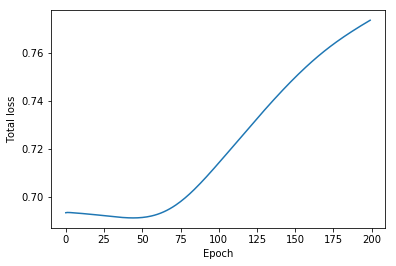

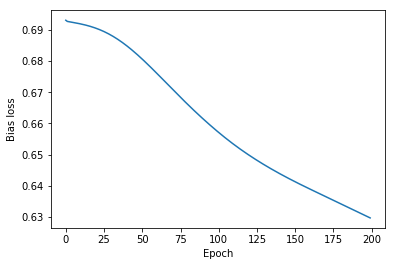

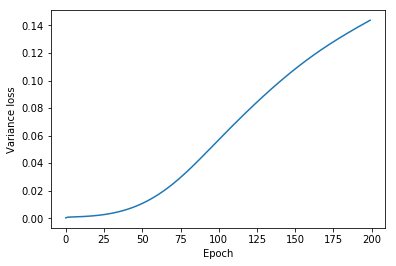

In [74]:
# xval loss, proxy for total error 
total_loss = np.array(fit.history['val_loss'][:200])
# training loss, proxy for bias error
bias = np.array(fit.history['loss'][:200])
# difference, proxy for variance error
variance = total_loss - bias

plt.plot(total_loss)
plt.ylabel('Total loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(bias)
plt.ylabel('Bias loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(variance)
plt.ylabel('Variance loss')
plt.xlabel('Epoch')
plt.show()

# note that training loss (bias) declines continuously
# total loss declines, reaches a minimum, then climbs as overfitting and variance increases
# http://scott.fortmann-roe.com/docs/BiasVariance.html



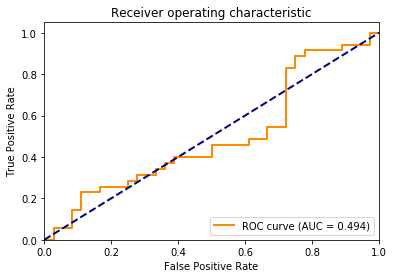

In [82]:
# ROC curve
 
(fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_xval, y_xval_prob)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# AUC of a coinflip is 0.5 so area under curve (AUC) of 0.494 is terrible
# even though some thresholds have predictive value

In [78]:
fpr

array([ 0.        ,  0.02777778,  0.02777778,  0.08333333,  0.08333333,
        0.11111111,  0.11111111,  0.16666667,  0.16666667,  0.25      ,
        0.25      ,  0.27777778,  0.27777778,  0.33333333,  0.33333333,
        0.36111111,  0.36111111,  0.38888889,  0.38888889,  0.5       ,
        0.5       ,  0.61111111,  0.61111111,  0.66666667,  0.66666667,
        0.72222222,  0.72222222,  0.75      ,  0.75      ,  0.77777778,
        0.77777778,  0.88888889,  0.88888889,  0.97222222,  0.97222222,  1.        ])

In [8]:
# 2nd, use Keras native k-fold cross-validation and grid search
# this will take ~ 15 minutes on AWS p2.xlarge

print('%s Starting' % time.strftime("%H:%M:%S"))

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=False)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# hyperparameter options to try
hidden_layer_hp = [4, 8, 16, 32]
dropout_hp = [0.333]
reg_penalty_hp = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
activation_hp = ['relu', 'sigmoid']

param_grid = dict(hidden_layer_size=hidden_layer_hp, 
                  dropout=dropout_hp, 
                  reg_penalty=reg_penalty_hp,
                  activation=activation_hp,
                  )

grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold, n_jobs=-1)
classifier = grid.fit(X_bigtrain, y_bigtrain)

print('%s Finishing' % time.strftime("%H:%M:%S"))

# summarize xval results
print("Best Xval: %f using %s" % (classifier.best_score_, classifier.best_params_))
means = classifier.cv_results_['mean_test_score']
stds = classifier.cv_results_['std_test_score']
params = classifier.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
        
# evaluate with test set
print("Evaluate performance in test set")
y_test_pred = classifier.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test_pred, y_test)
print(confusion_matrix)

print("Test Accuracy %.3f" % sklearn.metrics.accuracy_score(y_test_pred, y_test))
print("Test F1 %.3f" % sklearn.metrics.f1_score(y_test_pred, y_test))

00:22:18 Starting
00:30:20 Finishing
Best Xval: 0.540925 using {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0.333, 'reg_penalty': 0}
0.508897 (0.067146) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0}
0.483986 (0.029291) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0.001}
0.483986 (0.023241) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0.003}
0.505338 (0.004347) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0.01}
0.505338 (0.004347) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0.03}
0.505338 (0.004347) with: {'activation': 'relu', 'hidden_layer_size': 4, 'dropout': 0.333, 'reg_penalty': 0.1}
0.540925 (0.016503) with: {'activation': 'relu', 'hidden_layer_size': 8, 'dropout': 0.333, 'reg_penalty': 0}
0.480427 (0.050019) with: {'activation': 'relu', 'hidden_layer_size': 8, 'd

In [10]:
# Finally, roll our own grid search
# more fine-grained control such as custom metric and threshold

# define some custom metrics
import keras.backend as K

def recall(y_true, y_pred):
    # return keras tensor for recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    # return keras tensor for precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def f_score(y_true, y_pred):
    beta = 1 #  can adjust to penalize false positives/negatives
    return fbeta_score(y_true, y_pred, beta=beta)

def selectThresholdF1 (logits, labels, beta=1):
    # return threshold, f-score that yields best F-score
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

def selectThresholdAcc (logits, labels, beta=1):
    # return threshold that yields best accuracy
    # predict using true if >= threshold

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    accuracies = [sklearn.metrics.accuracy_score(logits >= thresh, labels) for thresh in thresholds]
    
    best_index = np.argmax(accuracies)
    best_threshold = thresholds[best_index]
    best_score = accuracies[best_index]
    return (best_threshold, best_score)

def selectThresholdTest (logits, labels, beta=1):
    # show all thresholds, resulting F1 and accuracy

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, logits)
    bb = beta**2
    f1_scores = (1 + bb) * precision * recall / (bb * precision + recall)
    f1_scores = np.nan_to_num(f1_scores)
    
    for thresh in thresholds:
        labels_pred = logits >= thresh
        f_test = sklearn.metrics.f1_score(labels_pred, labels)
        acc_test = sklearn.metrics.accuracy_score(labels_pred, labels)
        
        print ("Threshold %f, f1 %f, accuracy %f") % (thresh, f_test, acc_test)
        print(sklearn.metrics.confusion_matrix(labels_pred, labels))
    
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    best_score = f1_scores[best_index]
    return (best_threshold, best_score)

In [23]:
# same as above, compile with custom metric
def create_model(num_components=num_features, 
                 hidden_layer_size=30, 
                 dropout=(1.0/3.0), 
                 reg_penalty=0.0001, 
                 activation='relu'):
    
    model = declare_model(num_components=num_components, 
                 hidden_layer_size=hidden_layer_size, 
                 dropout=dropout, 
                 reg_penalty=reg_penalty, 
                 activation=activation)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f_score])
    return model


In [24]:
# delete old saved model files
!rm model*.json
!rm model*.h5

rm: cannot remove 'model*.json': No such file or directory
rm: cannot remove 'model*.h5': No such file or directory


In [25]:
# hyperparameter options to try
hidden_layer_hp = [4, 8, 16, 32]
dropout_hp = [0, 0.333, 0.5]
reg_penalty_hp = [0, 0.0001, 0.0003, 0.001, 0.003]
activation_hp = ['relu', 'sigmoid']

fscores = {}

for dr in dropout_hp:
    for ac in activation_hp:
        for hl in hidden_layer_hp:
            for rp in reg_penalty_hp:
                # print("\n %s\n" % (time.strftime("%H:%M:%S")))               

                model = create_model(num_components=num_features,
                                     hidden_layer_size=hl, 
                                     dropout=dr, 
                                     reg_penalty=rp,
                                     activation=ac)
                
                models = []
                losses = []
    
    
                epochs = 100 # increase this if Xval_loss doesn't always reach a minimum in this many epochs
                print('%s Starting' % time.strftime("%H:%M:%S"))             
                
                for i in range(epochs):
                    fit = model.fit(X_train, y_train, validation_data=(X_xval, y_xval), 
                                    epochs=1, 
                                    batch_size=X_train.shape[0], # small data, full batch, no sgd 
                                    verbose=False)
                    train_loss = fit.history['loss'][-1]
                    train_acc = fit.history['acc'][-1]
                    train_f_score = fit.history['f_score'][-1]
                    current_loss = fit.history['val_loss'][-1]
                    current_acc = fit.history['val_acc'][-1]
                    current_f_score = fit.history['val_f_score'][-1]
                    if i % 10 == 0:
                        print('%s epoch %d of %d Train loss: %.4f Train f_score %.4f Xval loss: %.4f Xval f_score %.4f' % 
                              (time.strftime("%H:%M:%S"), i, epochs,
                               train_loss, train_f_score,
                               current_loss, current_f_score))
                    
                    losses.append(current_loss)
                    models.append(copy.copy(model))
                    
                    bestloss_index = np.argmin(losses)
                    bestloss_value = losses[bestloss_index]
                    # stop if loss rises by 10% from best
                    if current_loss / bestloss_value > 1.1:
                        break
                    
                # keep model from epoch with best xval loss
                print ("Best Xval loss epoch %d, value %f" % (bestloss_index, bestloss_value))
                model = models[bestloss_index]

                # evaluate model
                print ("NN units %d" % hl)
                print ("Reg_penalty %.8f" % rp)
                print ("Dropout %.4f" %  dr)
                print ("Activation %s" %  ac)
                
                y_train_prob = model.predict(X_train)
                
                thresh, score = selectThresholdAcc(y_train_prob, y_train)
                y_train_pred = y_train_prob >= thresh
                
                print("Final Train Accuracy %.3f, Train F1 %.3f" % 
                      (sklearn.metrics.accuracy_score(y_train_pred, y_train), 
                       sklearn.metrics.f1_score(y_train_pred, y_train)))
                
                print(sklearn.metrics.confusion_matrix(y_train_pred, y_train))

                y_xval_prob = model.predict(X_xval)
                
                thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
                y_xval_pred = y_xval_prob >= thresh
                
                print("Final Xval Accuracy %.3f, Xval F1 %.3f" % 
                      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
                       sklearn.metrics.f1_score(y_xval_pred, y_xval)))
                                
                confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
                print(confusion_matrix)
                true_negative = confusion_matrix[0][0]
                false_negative = confusion_matrix[0][1]
                false_positive = confusion_matrix[1][0]
                true_positive = confusion_matrix[1][1]

                fscores[(hl, rp, dr, ac)] = score

                # save model to disk
                modelname = "model_%s_%d_%.3f_%.6f" % (ac, hl, dr, rp)
                model.save("%s.h5" % modelname)
                model.save_weights("%s_weights.h5" % modelname)
                with open("%s.json" % modelname, "wb") as fjson:
                    fjson.write(model.to_json())                

print('%s Finishing' % time.strftime("%H:%M:%S"))


00:35:20 Starting
00:35:21 epoch 0 of 100 Train loss: 0.6932 Train f_score 0.2256 Xval loss: 0.6928 Xval f_score 0.5075
00:35:21 epoch 10 of 100 Train loss: 0.6924 Train f_score 0.6642 Xval loss: 0.6929 Xval f_score 0.6374
00:35:21 epoch 20 of 100 Train loss: 0.6915 Train f_score 0.6540 Xval loss: 0.6930 Xval f_score 0.5843
00:35:21 epoch 30 of 100 Train loss: 0.6903 Train f_score 0.6486 Xval loss: 0.6931 Xval f_score 0.5843
00:35:21 epoch 40 of 100 Train loss: 0.6884 Train f_score 0.6423 Xval loss: 0.6931 Xval f_score 0.5977
00:35:21 epoch 50 of 100 Train loss: 0.6860 Train f_score 0.6307 Xval loss: 0.6930 Xval f_score 0.6118
00:35:21 epoch 60 of 100 Train loss: 0.6829 Train f_score 0.6160 Xval loss: 0.6928 Xval f_score 0.5854
00:35:21 epoch 70 of 100 Train loss: 0.6794 Train f_score 0.6298 Xval loss: 0.6929 Xval f_score 0.5926
00:35:21 epoch 80 of 100 Train loss: 0.6754 Train f_score 0.6234 Xval loss: 0.6934 Xval f_score 0.6000
00:35:21 epoch 90 of 100 Train loss: 0.6713 Train f_scor

Best Xval loss epoch 12, value 0.693477
NN units 8
Reg_penalty 0.00010000
Dropout 0.0000
Activation relu
Final Train Accuracy 0.667, Train F1 0.646
[[76 43]
 [27 64]]
Final Xval Accuracy 0.577, Xval F1 0.348
[[33 27]
 [ 3  8]]
00:35:29 Starting
00:35:30 epoch 0 of 100 Train loss: 0.6965 Train f_score 0.3537 Xval loss: 0.6957 Xval f_score 0.4068
00:35:30 epoch 10 of 100 Train loss: 0.6945 Train f_score 0.6142 Xval loss: 0.6953 Xval f_score 0.5647
00:35:30 epoch 20 of 100 Train loss: 0.6929 Train f_score 0.6595 Xval loss: 0.6952 Xval f_score 0.6105
00:35:30 epoch 30 of 100 Train loss: 0.6907 Train f_score 0.6831 Xval loss: 0.6951 Xval f_score 0.6250
00:35:30 epoch 40 of 100 Train loss: 0.6878 Train f_score 0.6739 Xval loss: 0.6948 Xval f_score 0.6237
00:35:30 epoch 50 of 100 Train loss: 0.6839 Train f_score 0.6794 Xval loss: 0.6943 Xval f_score 0.6374
00:35:30 epoch 60 of 100 Train loss: 0.6793 Train f_score 0.6613 Xval loss: 0.6939 Xval f_score 0.6279
00:35:30 epoch 70 of 100 Train loss

Best Xval loss epoch 45, value 0.700626
NN units 16
Reg_penalty 0.00100000
Dropout 0.0000
Activation relu
Final Train Accuracy 0.662, Train F1 0.687
[[61 29]
 [42 78]]
Final Xval Accuracy 0.549, Xval F1 0.610
[[14 10]
 [22 25]]
00:35:40 Starting
00:35:41 epoch 0 of 100 Train loss: 0.7474 Train f_score 0.6485 Xval loss: 0.7459 Xval f_score 0.6304
00:35:41 epoch 10 of 100 Train loss: 0.7338 Train f_score 0.6624 Xval loss: 0.7333 Xval f_score 0.6337
00:35:41 epoch 20 of 100 Train loss: 0.7223 Train f_score 0.6751 Xval loss: 0.7228 Xval f_score 0.6604
00:35:41 epoch 30 of 100 Train loss: 0.7133 Train f_score 0.6751 Xval loss: 0.7143 Xval f_score 0.6604
00:35:41 epoch 40 of 100 Train loss: 0.7066 Train f_score 0.6751 Xval loss: 0.7079 Xval f_score 0.6604
00:35:41 epoch 50 of 100 Train loss: 0.7015 Train f_score 0.6751 Xval loss: 0.7029 Xval f_score 0.6604
00:35:41 epoch 60 of 100 Train loss: 0.6978 Train f_score 0.6751 Xval loss: 0.6994 Xval f_score 0.6604
00:35:41 epoch 70 of 100 Train los

Best Xval loss epoch 86, value 0.690620
NN units 4
Reg_penalty 0.00000000
Dropout 0.0000
Activation sigmoid
Final Train Accuracy 0.581, Train F1 0.681
[[28 13]
 [75 94]]
Final Xval Accuracy 0.563, Xval F1 0.597
[[17 12]
 [19 23]]
00:35:54 Starting
00:35:55 epoch 0 of 100 Train loss: 0.6948 Train f_score 0.0000 Xval loss: 0.6942 Xval f_score 0.0000
00:35:55 epoch 10 of 100 Train loss: 0.6940 Train f_score 0.6601 Xval loss: 0.6941 Xval f_score 0.6337
00:35:55 epoch 20 of 100 Train loss: 0.6935 Train f_score 0.6751 Xval loss: 0.6941 Xval f_score 0.6604
00:35:55 epoch 30 of 100 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6940 Xval f_score 0.6604
00:35:55 epoch 40 of 100 Train loss: 0.6927 Train f_score 0.6751 Xval loss: 0.6938 Xval f_score 0.6604
00:35:55 epoch 50 of 100 Train loss: 0.6922 Train f_score 0.6751 Xval loss: 0.6936 Xval f_score 0.6604
00:35:55 epoch 60 of 100 Train loss: 0.6917 Train f_score 0.6794 Xval loss: 0.6934 Xval f_score 0.6476
00:35:55 epoch 70 of 100 Train l

00:36:08 epoch 90 of 100 Train loss: 0.6874 Train f_score 0.6345 Xval loss: 0.6948 Xval f_score 0.5926
Best Xval loss epoch 58, value 0.694420
NN units 8
Reg_penalty 0.00030000
Dropout 0.0000
Activation sigmoid
Final Train Accuracy 0.590, Train F1 0.636
[[49 32]
 [54 75]]
Final Xval Accuracy 0.549, Xval F1 0.628
[[12  8]
 [24 27]]
00:36:09 Starting
00:36:10 epoch 0 of 100 Train loss: 0.7051 Train f_score 0.0000 Xval loss: 0.7029 Xval f_score 0.0000
00:36:10 epoch 10 of 100 Train loss: 0.7011 Train f_score 0.0000 Xval loss: 0.7000 Xval f_score 0.0000
00:36:10 epoch 20 of 100 Train loss: 0.6983 Train f_score 0.0000 Xval loss: 0.6983 Xval f_score 0.0000
00:36:10 epoch 30 of 100 Train loss: 0.6966 Train f_score 0.6275 Xval loss: 0.6972 Xval f_score 0.5979
00:36:10 epoch 40 of 100 Train loss: 0.6954 Train f_score 0.6751 Xval loss: 0.6965 Xval f_score 0.6604
00:36:10 epoch 50 of 100 Train loss: 0.6947 Train f_score 0.6751 Xval loss: 0.6960 Xval f_score 0.6604
00:36:10 epoch 60 of 100 Train l

00:36:25 epoch 90 of 100 Train loss: 0.6937 Train f_score 0.6751 Xval loss: 0.6943 Xval f_score 0.6604
Best Xval loss epoch 99, value 0.694009
NN units 16
Reg_penalty 0.00300000
Dropout 0.0000
Activation sigmoid
Final Train Accuracy 0.519, Train F1 0.673
[[  5   3]
 [ 98 104]]
Final Xval Accuracy 0.549, Xval F1 0.652
[[ 9  5]
 [27 30]]
00:36:26 Starting
00:36:27 epoch 0 of 100 Train loss: 0.6958 Train f_score 0.0000 Xval loss: 0.6934 Xval f_score 0.0000
00:36:27 epoch 10 of 100 Train loss: 0.6912 Train f_score 0.6667 Xval loss: 0.6928 Xval f_score 0.6476
00:36:27 epoch 20 of 100 Train loss: 0.6894 Train f_score 0.6731 Xval loss: 0.6920 Xval f_score 0.6538
00:36:27 epoch 30 of 100 Train loss: 0.6872 Train f_score 0.6198 Xval loss: 0.6904 Xval f_score 0.5854
00:36:27 epoch 40 of 100 Train loss: 0.6850 Train f_score 0.5727 Xval loss: 0.6900 Xval f_score 0.5641
00:36:27 epoch 50 of 100 Train loss: 0.6824 Train f_score 0.6034 Xval loss: 0.6901 Xval f_score 0.5679
00:36:27 epoch 60 of 100 Tr

00:36:44 epoch 80 of 100 Train loss: 0.6832 Train f_score 0.6332 Xval loss: 0.6942 Xval f_score 0.5647
00:36:44 epoch 90 of 100 Train loss: 0.6774 Train f_score 0.6560 Xval loss: 0.6945 Xval f_score 0.5301
Best Xval loss epoch 43, value 0.693259
NN units 4
Reg_penalty 0.00010000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.614, Train F1 0.675
[[45 23]
 [58 84]]
Final Xval Accuracy 0.577, Xval F1 0.400
[[31 25]
 [ 5 10]]
00:36:46 Starting
00:36:47 epoch 0 of 100 Train loss: 0.6933 Train f_score 0.5893 Xval loss: 0.6956 Xval f_score 0.6087
00:36:47 epoch 10 of 100 Train loss: 0.6925 Train f_score 0.6689 Xval loss: 0.6959 Xval f_score 0.6731
00:36:47 epoch 20 of 100 Train loss: 0.6924 Train f_score 0.6796 Xval loss: 0.6961 Xval f_score 0.6667
00:36:47 epoch 30 of 100 Train loss: 0.6911 Train f_score 0.6861 Xval loss: 0.6963 Xval f_score 0.6667
00:36:47 epoch 40 of 100 Train loss: 0.6883 Train f_score 0.6908 Xval loss: 0.6967 Xval f_score 0.6731
00:36:47 epoch 50 of 100 Train loss

00:37:07 epoch 80 of 100 Train loss: 0.6865 Train f_score 0.6306 Xval loss: 0.6953 Xval f_score 0.6133
00:37:07 epoch 90 of 100 Train loss: 0.6825 Train f_score 0.6204 Xval loss: 0.6950 Xval f_score 0.5946
Best Xval loss epoch 97, value 0.694943
NN units 8
Reg_penalty 0.00100000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.624, Train F1 0.661
[[54 30]
 [49 77]]
Final Xval Accuracy 0.606, Xval F1 0.632
[[19 11]
 [17 24]]
00:37:08 Starting
00:37:10 epoch 0 of 100 Train loss: 0.7215 Train f_score 0.5098 Xval loss: 0.7215 Xval f_score 0.5753
00:37:10 epoch 10 of 100 Train loss: 0.7145 Train f_score 0.6758 Xval loss: 0.7153 Xval f_score 0.6535
00:37:10 epoch 20 of 100 Train loss: 0.7095 Train f_score 0.6709 Xval loss: 0.7101 Xval f_score 0.6604
00:37:10 epoch 30 of 100 Train loss: 0.7047 Train f_score 0.6730 Xval loss: 0.7058 Xval f_score 0.6604
00:37:10 epoch 40 of 100 Train loss: 0.7014 Train f_score 0.6772 Xval loss: 0.7027 Xval f_score 0.6604
00:37:10 epoch 50 of 100 Train loss

00:37:32 epoch 70 of 100 Train loss: 0.6308 Train f_score 0.6667 Xval loss: 0.6981 Xval f_score 0.5143
00:37:32 epoch 80 of 100 Train loss: 0.6206 Train f_score 0.6727 Xval loss: 0.7020 Xval f_score 0.5000
00:37:32 epoch 90 of 100 Train loss: 0.6159 Train f_score 0.6759 Xval loss: 0.7066 Xval f_score 0.4658
Best Xval loss epoch 20, value 0.691316
NN units 32
Reg_penalty 0.00000000
Dropout 0.3330
Activation relu
Final Train Accuracy 0.705, Train F1 0.696
[[77 36]
 [26 71]]
Final Xval Accuracy 0.563, Xval F1 0.311
[[33 28]
 [ 3  7]]
00:37:34 Starting
00:37:35 epoch 0 of 100 Train loss: 0.6945 Train f_score 0.6577 Xval loss: 0.6963 Xval f_score 0.6538
00:37:35 epoch 10 of 100 Train loss: 0.6890 Train f_score 0.6667 Xval loss: 0.6965 Xval f_score 0.6327
00:37:35 epoch 20 of 100 Train loss: 0.6853 Train f_score 0.6667 Xval loss: 0.6968 Xval f_score 0.6067
00:37:36 epoch 30 of 100 Train loss: 0.6789 Train f_score 0.6773 Xval loss: 0.6976 Xval f_score 0.5432
00:37:36 epoch 40 of 100 Train los

00:37:58 epoch 0 of 100 Train loss: 0.6940 Train f_score 0.5182 Xval loss: 0.6946 Xval f_score 0.5870
00:37:58 epoch 10 of 100 Train loss: 0.6945 Train f_score 0.5899 Xval loss: 0.6944 Xval f_score 0.6604
00:37:58 epoch 20 of 100 Train loss: 0.6941 Train f_score 0.6751 Xval loss: 0.6943 Xval f_score 0.6604
00:37:58 epoch 30 of 100 Train loss: 0.6935 Train f_score 0.6751 Xval loss: 0.6942 Xval f_score 0.6604
00:37:58 epoch 40 of 100 Train loss: 0.6936 Train f_score 0.6751 Xval loss: 0.6941 Xval f_score 0.6604
00:37:59 epoch 50 of 100 Train loss: 0.6926 Train f_score 0.6751 Xval loss: 0.6940 Xval f_score 0.6604
00:37:59 epoch 60 of 100 Train loss: 0.6943 Train f_score 0.6751 Xval loss: 0.6939 Xval f_score 0.6604
00:37:59 epoch 70 of 100 Train loss: 0.6933 Train f_score 0.6751 Xval loss: 0.6939 Xval f_score 0.6604
00:37:59 epoch 80 of 100 Train loss: 0.6916 Train f_score 0.6751 Xval loss: 0.6938 Xval f_score 0.6604
00:37:59 epoch 90 of 100 Train loss: 0.6928 Train f_score 0.6751 Xval loss

00:38:24 epoch 70 of 100 Train loss: 0.6953 Train f_score 0.6022 Xval loss: 0.6945 Xval f_score 0.6604
00:38:24 epoch 80 of 100 Train loss: 0.6943 Train f_score 0.6392 Xval loss: 0.6942 Xval f_score 0.6604
00:38:24 epoch 90 of 100 Train loss: 0.6939 Train f_score 0.6338 Xval loss: 0.6941 Xval f_score 0.6604
Best Xval loss epoch 98, value 0.694069
NN units 8
Reg_penalty 0.00100000
Dropout 0.3330
Activation sigmoid
Final Train Accuracy 0.595, Train F1 0.653
[[45 27]
 [58 80]]
Final Xval Accuracy 0.606, Xval F1 0.674
[[14  6]
 [22 29]]
00:38:26 Starting
00:38:28 epoch 0 of 100 Train loss: 0.7210 Train f_score 0.6667 Xval loss: 0.7196 Xval f_score 0.6604
00:38:28 epoch 10 of 100 Train loss: 0.7147 Train f_score 0.6309 Xval loss: 0.7129 Xval f_score 0.6604
00:38:28 epoch 20 of 100 Train loss: 0.7061 Train f_score 0.6426 Xval loss: 0.7075 Xval f_score 0.6604
00:38:28 epoch 30 of 100 Train loss: 0.7038 Train f_score 0.6192 Xval loss: 0.7035 Xval f_score 0.6604
00:38:28 epoch 40 of 100 Train l

00:38:53 Starting
00:38:56 epoch 0 of 100 Train loss: 0.6932 Train f_score 0.2388 Xval loss: 0.6938 Xval f_score 0.0000
00:38:56 epoch 10 of 100 Train loss: 0.6914 Train f_score 0.5882 Xval loss: 0.6934 Xval f_score 0.6275
00:38:56 epoch 20 of 100 Train loss: 0.6946 Train f_score 0.6143 Xval loss: 0.6936 Xval f_score 0.6408
00:38:56 epoch 30 of 100 Train loss: 0.6933 Train f_score 0.5918 Xval loss: 0.6928 Xval f_score 0.6105
00:38:56 epoch 40 of 100 Train loss: 0.6910 Train f_score 0.5579 Xval loss: 0.6922 Xval f_score 0.5714
00:38:56 epoch 50 of 100 Train loss: 0.6893 Train f_score 0.5422 Xval loss: 0.6920 Xval f_score 0.5679
00:38:56 epoch 60 of 100 Train loss: 0.6878 Train f_score 0.5714 Xval loss: 0.6920 Xval f_score 0.5610
00:38:56 epoch 70 of 100 Train loss: 0.6871 Train f_score 0.6076 Xval loss: 0.6919 Xval f_score 0.5750
00:38:56 epoch 80 of 100 Train loss: 0.6847 Train f_score 0.5714 Xval loss: 0.6919 Xval f_score 0.5823
00:38:56 epoch 90 of 100 Train loss: 0.6792 Train f_scor

00:39:25 epoch 70 of 100 Train loss: 0.6839 Train f_score 0.6643 Xval loss: 0.6916 Xval f_score 0.6136
00:39:25 epoch 80 of 100 Train loss: 0.6810 Train f_score 0.6561 Xval loss: 0.6914 Xval f_score 0.5882
00:39:25 epoch 90 of 100 Train loss: 0.6778 Train f_score 0.6667 Xval loss: 0.6909 Xval f_score 0.5854
Best Xval loss epoch 99, value 0.690434
NN units 4
Reg_penalty 0.00010000
Dropout 0.5000
Activation relu
Final Train Accuracy 0.633, Train F1 0.678
[[52 26]
 [51 81]]
Final Xval Accuracy 0.592, Xval F1 0.431
[[31 24]
 [ 5 11]]
00:39:27 Starting
00:39:30 epoch 0 of 100 Train loss: 0.6941 Train f_score 0.5859 Xval loss: 0.6942 Xval f_score 0.6604
00:39:30 epoch 10 of 100 Train loss: 0.6933 Train f_score 0.6751 Xval loss: 0.6940 Xval f_score 0.6604
00:39:30 epoch 20 of 100 Train loss: 0.6932 Train f_score 0.6751 Xval loss: 0.6937 Xval f_score 0.6604
00:39:30 epoch 30 of 100 Train loss: 0.6931 Train f_score 0.6751 Xval loss: 0.6934 Xval f_score 0.6604
00:39:30 epoch 40 of 100 Train loss

00:40:00 epoch 0 of 100 Train loss: 0.7013 Train f_score 0.6340 Xval loss: 0.7019 Xval f_score 0.6535
00:40:00 epoch 10 of 100 Train loss: 0.6992 Train f_score 0.6579 Xval loss: 0.7003 Xval f_score 0.6604
00:40:00 epoch 20 of 100 Train loss: 0.6962 Train f_score 0.6688 Xval loss: 0.6990 Xval f_score 0.6604
00:40:00 epoch 30 of 100 Train loss: 0.6943 Train f_score 0.6752 Xval loss: 0.6981 Xval f_score 0.6604
00:40:00 epoch 40 of 100 Train loss: 0.6950 Train f_score 0.6773 Xval loss: 0.6972 Xval f_score 0.6476
00:40:01 epoch 50 of 100 Train loss: 0.6925 Train f_score 0.6688 Xval loss: 0.6965 Xval f_score 0.6538
00:40:01 epoch 60 of 100 Train loss: 0.6929 Train f_score 0.6490 Xval loss: 0.6960 Xval f_score 0.6400
00:40:01 epoch 70 of 100 Train loss: 0.6899 Train f_score 0.6722 Xval loss: 0.6957 Xval f_score 0.6667
00:40:01 epoch 80 of 100 Train loss: 0.6841 Train f_score 0.6154 Xval loss: 0.6953 Xval f_score 0.6512
00:40:01 epoch 90 of 100 Train loss: 0.6899 Train f_score 0.5577 Xval loss

00:40:35 epoch 70 of 100 Train loss: 0.6969 Train f_score 0.6861 Xval loss: 0.6992 Xval f_score 0.6538
00:40:35 epoch 80 of 100 Train loss: 0.6950 Train f_score 0.6775 Xval loss: 0.6979 Xval f_score 0.6471
00:40:35 epoch 90 of 100 Train loss: 0.6949 Train f_score 0.6732 Xval loss: 0.6972 Xval f_score 0.6471
Best Xval loss epoch 99, value 0.696882
NN units 16
Reg_penalty 0.00300000
Dropout 0.5000
Activation relu
Final Train Accuracy 0.595, Train F1 0.693
[[29 11]
 [74 96]]
Final Xval Accuracy 0.521, Xval F1 0.630
[[ 8  6]
 [28 29]]
00:40:38 Starting
00:40:40 epoch 0 of 100 Train loss: 0.6947 Train f_score 0.4179 Xval loss: 0.6946 Xval f_score 0.4127
00:40:40 epoch 10 of 100 Train loss: 0.6875 Train f_score 0.6471 Xval loss: 0.6944 Xval f_score 0.5250
00:40:40 epoch 20 of 100 Train loss: 0.6827 Train f_score 0.5983 Xval loss: 0.6943 Xval f_score 0.5432
00:40:40 epoch 30 of 100 Train loss: 0.6750 Train f_score 0.6463 Xval loss: 0.6944 Xval f_score 0.5000
00:40:40 epoch 40 of 100 Train los

00:41:15 epoch 0 of 100 Train loss: 0.6944 Train f_score 0.3415 Xval loss: 0.6938 Xval f_score 0.0000
00:41:15 epoch 10 of 100 Train loss: 0.6928 Train f_score 0.5213 Xval loss: 0.6937 Xval f_score 0.2308
00:41:15 epoch 20 of 100 Train loss: 0.6943 Train f_score 0.5656 Xval loss: 0.6938 Xval f_score 0.6604
00:41:15 epoch 30 of 100 Train loss: 0.6904 Train f_score 0.6807 Xval loss: 0.6939 Xval f_score 0.6604
00:41:15 epoch 40 of 100 Train loss: 0.6941 Train f_score 0.6290 Xval loss: 0.6939 Xval f_score 0.6604
00:41:15 epoch 50 of 100 Train loss: 0.6945 Train f_score 0.6069 Xval loss: 0.6940 Xval f_score 0.6604
00:41:15 epoch 60 of 100 Train loss: 0.6941 Train f_score 0.6411 Xval loss: 0.6939 Xval f_score 0.6604
00:41:15 epoch 70 of 100 Train loss: 0.6935 Train f_score 0.6176 Xval loss: 0.6939 Xval f_score 0.6604
00:41:15 epoch 80 of 100 Train loss: 0.6938 Train f_score 0.6282 Xval loss: 0.6938 Xval f_score 0.6346
00:41:15 epoch 90 of 100 Train loss: 0.6941 Train f_score 0.5771 Xval loss

00:41:54 epoch 60 of 100 Train loss: 0.6923 Train f_score 0.6290 Xval loss: 0.6949 Xval f_score 0.6476
00:41:54 epoch 70 of 100 Train loss: 0.6920 Train f_score 0.5976 Xval loss: 0.6948 Xval f_score 0.6476
00:41:54 epoch 80 of 100 Train loss: 0.6921 Train f_score 0.6264 Xval loss: 0.6948 Xval f_score 0.6346
00:41:54 epoch 90 of 100 Train loss: 0.6889 Train f_score 0.6230 Xval loss: 0.6947 Xval f_score 0.6408
Best Xval loss epoch 91, value 0.694703
NN units 8
Reg_penalty 0.00030000
Dropout 0.5000
Activation sigmoid
Final Train Accuracy 0.586, Train F1 0.599
[[58 42]
 [45 65]]
Final Xval Accuracy 0.577, Xval F1 0.595
[[19 13]
 [17 22]]
00:41:57 Starting
00:42:00 epoch 0 of 100 Train loss: 0.7015 Train f_score 0.4000 Xval loss: 0.7023 Xval f_score 0.0000
00:42:00 epoch 10 of 100 Train loss: 0.7001 Train f_score 0.4712 Xval loss: 0.7002 Xval f_score 0.3636
00:42:00 epoch 20 of 100 Train loss: 0.6976 Train f_score 0.6245 Xval loss: 0.6986 Xval f_score 0.6604
00:42:00 epoch 30 of 100 Train l

00:42:36 Starting
00:42:39 epoch 0 of 100 Train loss: 0.7478 Train f_score 0.3871 Xval loss: 0.7457 Xval f_score 0.0000
00:42:39 epoch 10 of 100 Train loss: 0.7364 Train f_score 0.4456 Xval loss: 0.7326 Xval f_score 0.1081
00:42:39 epoch 20 of 100 Train loss: 0.7296 Train f_score 0.4476 Xval loss: 0.7225 Xval f_score 0.6604
00:42:39 epoch 30 of 100 Train loss: 0.7159 Train f_score 0.5868 Xval loss: 0.7149 Xval f_score 0.6604
00:42:39 epoch 40 of 100 Train loss: 0.7066 Train f_score 0.5897 Xval loss: 0.7088 Xval f_score 0.6604
00:42:39 epoch 50 of 100 Train loss: 0.7057 Train f_score 0.5891 Xval loss: 0.7041 Xval f_score 0.6604
00:42:39 epoch 60 of 100 Train loss: 0.7016 Train f_score 0.5714 Xval loss: 0.7006 Xval f_score 0.6604
00:42:39 epoch 70 of 100 Train loss: 0.6990 Train f_score 0.5669 Xval loss: 0.6980 Xval f_score 0.6604
00:42:39 epoch 80 of 100 Train loss: 0.6970 Train f_score 0.6016 Xval loss: 0.6964 Xval f_score 0.6604
00:42:39 epoch 90 of 100 Train loss: 0.6966 Train f_scor

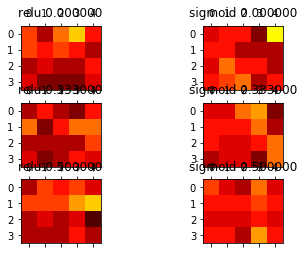



Dropout 0.000000 Activation: relu 
array([[ 0.5915493 ,  0.54929577,  0.6056338 ,  0.63380282,  0.57746479],
       [ 0.5915493 ,  0.57746479,  0.5915493 ,  0.57746479,  0.54929577],
       [ 0.54929577,  0.56338028,  0.54929577,  0.54929577,  0.57746479],
       [ 0.56338028,  0.53521127,  0.53521127,  0.53521127,  0.56338028]])

Max: 0.633803
Avg: 0.568310
Col Avg: array([ 0.57394366,  0.55633803,  0.57042254,  0.57394366,  0.56690141])
Row Avg: array([ 0.5915493 ,  0.57746479,  0.55774648,  0.54647887])


Dropout 0.000000 Activation: sigmoid 
array([[ 0.56338028,  0.57746479,  0.57746479,  0.53521127,  0.64788732],
       [ 0.57746479,  0.57746479,  0.54929577,  0.54929577,  0.54929577],
       [ 0.56338028,  0.6056338 ,  0.57746479,  0.57746479,  0.54929577],
       [ 0.57746479,  0.5915493 ,  0.6056338 ,  0.54929577,  0.57746479]])

Max: 0.647887
Avg: 0.573944
Col Avg: array([ 0.57042254,  0.58802817,  0.57746479,  0.5528169 ,  0.58098592])
Row Avg: array([ 0.58028169,  0.560563

In [29]:
#visualize evaluations in a grid to pick one
#hidden_layer_hp = [4, 8, 16, 32]
#dropout_hp = [0, 0.333, 0.5]
#reg_penalty_hp = [0, 0.0001, 0.0003, 0.001, 0.003]
#activation_hp = ['relu']

f, subplots = plt.subplots(len(dropout_hp), len(activation_hp))

outstr = ""

rownum=0
for dr in dropout_hp:
    colnum = 0
    for ac in activation_hp:
        matrix1 = []
        for hl in hidden_layer_hp:
            row = []
            for reg_penalty in reg_penalty_hp:
                try:
                    row.append(fscores[(hl, reg_penalty, dr, ac)])
                except KeyError:
                    row.append(0.00)
            matrix1.append(row)
            
        outstr += "\n\nDropout %f Activation: %s \n" % (dr, ac)
        outstr += repr(np.array(matrix1))
        outstr += "\n\nMax: %f\n" % (np.max(np.array(matrix1)))
        outstr += "Avg: %f\n" % (np.average(np.array(matrix1)))
        outstr += "Col Avg: %s\n" % repr(np.average(np.array(matrix1), axis=0))
        outstr += "Row Avg: %s\n" % repr(np.average(np.array(matrix1), axis=1))

        subplots[rownum, colnum].matshow(matrix1, cmap='hot', vmin=0.5, vmax=0.7, interpolation='nearest')
        subplots[rownum, colnum].set_title('%s %f' % (ac, dr))

        colnum += 1  
    rownum += 1

plt.show()

print(outstr)


In [36]:
# pick this model, load from file
ac='sigmoid'
hl = 8
dr = 0.5
rp = 0.001
modelname = "model_%s_%d_%.3f_%.6f" % (ac, hl, dr, rp)

# doesn't work because of some custom metric BS
#keras.models.load_model("%s.h5" % modelname)
from keras.models import model_from_json

with open("%s.json" % modelname, 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("%s_weights.h5" % modelname)
print("Loaded model from disk")



Loaded model from disk


In [37]:
# re-evaluate in xval to confirm, pick threshold value
y_xval_prob = model.predict(X_xval)
                
thresh, score = selectThresholdAcc(y_xval_prob, y_xval)
y_xval_pred = y_xval_prob >= thresh
                
print("Final Xval Accuracy %.3f, Xval F1 %.3f, f_score %.3f" % 
      (sklearn.metrics.accuracy_score(y_xval_pred, y_xval), 
       sklearn.metrics.f1_score(y_xval_pred, y_xval),
       score))
                                
confusion_matrix = sklearn.metrics.confusion_matrix(y_xval_pred, y_xval)
print(confusion_matrix)
false_positive = confusion_matrix[1][0]
false_negative = confusion_matrix[0][1]
true_positive = confusion_matrix[1][1]


Final Xval Accuracy 0.592, Xval F1 0.603, f_score 0.592
[[20 13]
 [16 22]]


In [ ]:
from scikitplot import classifier_factory
classifier_factory(model)
model.plot_roc_curve(X_xval, y_xval, random_state=1)
plt.show()

In [38]:
# evaluate in test set
# xval not a good measure of expected performance since we used it to pick threshold
# also tested many times in xval and picked best model, which is probably model that's lucky in xval
y_test_prob = model.predict(X_test)

y_test_pred = y_test_prob >= thresh

print("Test Accuracy %.3f, Test F1 %.3f" % 
      (sklearn.metrics.accuracy_score(y_test_pred, y_test), 
       sklearn.metrics.f1_score(y_test_pred, y_test)))

print(sklearn.metrics.confusion_matrix(y_test_pred, y_test))

Test Accuracy 0.535, Test F1 0.602
[[13  9]
 [24 25]]


In [39]:
model.save("finalmodel.h5")
model.save_weights("modelweights.h5")

with open("finalmodel.json", "wb") as fjson:
    fjson.write(model.to_json())

In [44]:
dir(grid.best_estimator_.model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_feed_input_names',
 '_feed_inputs',
 '_fit_loop',
 '_flattened_layers',
 '_gather_list_attr',
 '_get_node_attribute_at_index',
 '_initial_weights',
 '_make_predict_function',
 '_make_test_function',
 '_make_train_function',
 '_output_mask_cache',
 '_output_shape_cache',
 '_output_tensor_cache',
 '_predict_loop',
 '_standardize_user_data',
 '_test_loop',
 '_trainable',
 '_updated_config',
 'add',
 'add_loss',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'build',
 'built',
 'call',
 'compile',
 'compute_mask',
 'compute_output_shape',
 'constraints',
 'container_nodes',
 'count_params',
 'evaluate',
 'evaluate_generator',
 'fit',
 'fit_generator',
 'f